# Figure 11: Calcium response

In [3]:
from setup_nb import *
from matplotlib.colors import hex2color
from scipy.misc import imread
from matplotlib import patheffects

In [4]:
def my_imread(path):
    return imread(path, mode="RGB") / 255.0

### Data

In [5]:
data = pd.read_hdf("../data/calcium.data")

In [6]:
data.head()

value
trial wave_length direction name                            jump_v_effective bg_intensity contrast flicker_on jump_dist rotation roi_id fly_id time              
0     60.0        1.0       stimuli.default.tuning_rphi_v_1 8.0              127.0        1.0      0.0        4.0       ND       l      fly10  -3.99360  0.360475
                                                                                                                                               -3.86048  0.210614
                                                                                                                                               -3.72736  0.266971
                                                                                                                                               -3.59424  0.287623
                                                                                                                                               -3.46112  0.291921

In [7]:
d_mean = groupexcept(data, "trial").mean()
d_eval = groupexcept(d_mean.xs(pd.IndexSlice[1.0:4.0], level="time", drop_level=False), "time")\
    .mean()
d_diff = d_eval.xs("PD", level="rotation") - d_eval.xs("ND", level="rotation")

In [8]:
img_mean = my_imread("static/T4T5_ctrl_rphi_v3_2016-12-15_13.47_mean_signal.png")
img_roi_t4 = my_imread("static/T4T5_ctrl_rphi_v3_2016-12-15_13.47_ROI1.png")
img_roi_t5 = my_imread("static/T4T5_ctrl_rphi_v3_2016-12-15_13.47_ROI2.png")

### Statistics

In [12]:
def ttest_velocity_single(my_evald, neuropil):
    
    vels = my_evald.index.levels[3]
    
    alpha = 0.05 / len(vels)
    sigs = []
    
    for vel in vels:
                
        values = my_evald.loc[pd.IndexSlice[:, :, :, vel, :, :, 1.0, :, neuropil, :], :].value.values
        ts1, p1 = ttest_1samp(values, 0.0)
        
        sig = (p1 < alpha)
        
        print "Velocity {0} jw: t = {1}, p = {2}".format(vel, ts1, p1)
        
        sigs.append(sig)
        
    return sigs

In [17]:
t4_sig = ttest_velocity_single(d_diff, "m")

Velocity 8.0 jw: t = -4.91585315123, p = 0.00117011611808
Velocity 16.0 jw: t = -5.94129730489, p = 0.000345331383866
Velocity 32.0 jw: t = -2.95556163617, p = 0.0182697072903
Velocity 64.0 jw: t = 5.20387234892, p = 0.000818523811295
Velocity 128.0 jw: t = 0.924837765904, p = 0.382100305193
Velocity 256.0 jw: t = -0.356159803292, p = 0.7309308862


In [18]:
t5_sig = ttest_velocity_single(d_diff, "l")

Velocity 8.0 jw: t = -4.86627393806, p = 0.00124584512884
Velocity 16.0 jw: t = -3.01127357553, p = 0.0167809661325
Velocity 32.0 jw: t = 2.8553534806, p = 0.0213030044195
Velocity 64.0 jw: t = 3.95601511682, p = 0.00420043229478
Velocity 128.0 jw: t = 2.75333337742, p = 0.0249301928693
Velocity 256.0 jw: t = 2.84172555118, p = 0.0217541427998


### Generic plot

In [21]:
def make_trace_panel(data, roi, vel, flicker, ax, ylim=[-200.0, 200.0], legend=False, title=""):
    
    data = data.reset_index()
    data["value"] = data["value"] * 100  # %
    data = data[(data.jump_v_effective == vel) & (data.roi_id == roi) & (data.flicker_on == flicker)]
                
    sb.tsplot(data, time="time", unit="fly_id", condition="rotation", value="value",
              ci=standard_ci, color=gt_colors, legend=legend, err_kws={'edgecolor': 'none'},
              ax=ax)
    
    ax.set_ylim(ylim)
    ax.set_xlim([-1.0, 5.0])
        
    if legend:
        
        hs, ls_ = ax.get_legend_handles_labels()
        ls = [gt_alias[x] for x in ls_]
        
        ax.legend_.remove()
                
        lorder = [ls_.index(direction) for direction in [u"PD", u"ND"]]
        hs, ls = [hs[idx] for idx in lorder], [ls[idx] for idx in lorder]
        
        ax.legend(hs, ls, loc=[0.0, 0.6], ncol=1)
        
        ax.legend_.set_title("")
    
    remove_axis(ax, x=True, y=True)
    
    ax.axvspan(0.0, 4.0, edgecolor='none', facecolor='gray', zorder=0, alpha=0.075)

    l = ax.plot(ax.get_xlim(), [0, 0], linestyle="--", zorder=1, color="#444444")
    l[0].set_dashes([1,1])
    
    ax.set_title(title)
    ax.patch.set_alpha(0.0)

In [22]:
def make_summary_panel(data, roi, ax, ylim=[-100, 100], legend=False):
    
    data = data.reset_index()
    data = data[data.roi_id == roi]
                
    sb.pointplot("jump_v_effective", "value", hue="flicker_on", data=data, palette=gt_colors,
                 scale=0.75, ax=ax, ci=standard_ci, legend=legend)
    
    add_refline(ax, horizontal=True)
    
    ax.set_xlabel(u"Pattern speed (°/s)", labelpad=2.0)
    ax.set_ylabel(u"PD − ND ΔF/F", labelpad=-1.0)
    
    ax.legend_.remove()

    if legend:
        
        hs, ls_ = ax.get_legend_handles_labels()
        ls = [gt_alias[x] for x in ls_]
                        
        lorder = [ls_.index(direction) for direction in [u"0.0", u"1.0"]]
        hs, ls = [hs[idx] for idx in lorder], [ls[idx] for idx in lorder]
        
        ax.legend(hs, ls, loc=[0.1, 1.0], ncol=1)
        
        ax.legend_.set_title("")
    
    ax.set_ylim(ylim)
    
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('center')

    yloc = mpl.ticker.MaxNLocator(4)
    ax.yaxis.set_major_locator(yloc)
    
    ax.set_xticklabels([8, 16, 32, 64, 128, 256])
    
    sb.despine(ax=ax)

In [23]:
def gen_overlay(overlay, color, alpha=0.6):
    
    new_overlay = np.ones((overlay.shape[0], overlay.shape[1], 4))
    new_overlay[:, :, [0, 1, 2]] = new_overlay[:, :, [0, 1, 2]] * hex2color(color)
    new_overlay[:, :, -1] = alpha * overlay[:, :, 0]
    
    return new_overlay

In [24]:
def panel_image(overlay, labels, ax, fs=18.0):
    
    ax.imshow(np.sqrt(img_mean), interpolation="nearest")

    if overlay: 
        ax.imshow(gen_overlay(img_roi_t4, gt_colors["ON"]), interpolation="nearest")
        ax.imshow(gen_overlay(img_roi_t5, gt_colors["OFF"]), interpolation="nearest")
    
    if labels:
        ax.text(12, 24, "Medulla", color="w",
                fontsize=fs, rotation=57.0, va="center", ha="center",
                path_effects=[patheffects.withStroke(linewidth=1, foreground="k")])

        ax.text(53, 20, "Lobula", color="w",
                fontsize=fs, rotation=-71.0, va="center", ha="center",
                path_effects=[patheffects.withStroke(linewidth=1, foreground="k")])

        ax.text(32, 46, "Lobula plate", color="w",
            fontsize=fs, rotation=0.0, va="center", ha="center",
            path_effects=[patheffects.withStroke(linewidth=1, foreground="k")])

        ax.text(2, 2, "T4c/T5c > GCaMP6m", color="w",
            fontsize=fs * 0.7, rotation=0.0, va="top", ha="left",
            path_effects=[patheffects.withStroke(linewidth=1, foreground="k")])
    
    remove_axis(ax, x=True, y=True)

In [25]:
def add_sidelabel(ax, label):
    
    ax.yaxis.set_visible(True)
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_ylabel(label, labelpad=0.0)

In [26]:
def add_asterisks(ax, x_locs, y_locs):
    for x, y in zip(x_locs, y_locs):
        ax.text(x, y, "*", horizontalalignment="center", verticalalignment="center")

In [53]:
def calcium_figure():
    
    off = 3.4
    off_v = -19.8
    rows = [0, 1.7, 3.8, 5.5, 8.2, -2.8]
    panelsize = (2, 2)
    panelsize_trace = (1.5, 2)

    fig = sb.plt.figure(figsize=[5.6, 2.9])
    
    trace_ylim = [-20, 1300]
    summary_ylim = [-5, 10]
    
    slow_speed = 16.0
    fast_speed = 64.0
    
    # T4:
    
    height = 24 + off_v
    layer = "m"
    
    ax = addaxis(fig, (off + rows[-1], height), panelsize, letter="a", nudge=0.0)
    panel_image(False, True, ax, fs=6.0)
    
    ax = addaxis(fig, (off + rows[0], height), panelsize_trace, letter="b", nudge=0.1)
    make_trace_panel(d_mean, layer, slow_speed, 0, ax, ylim=trace_ylim, legend=False,
                     title=u"Phi\n{0:.0f} °/s".format(slow_speed))
    add_sidelabel(ax, "T4c dendrites\n(medulla)")
    
    ax = addaxis(fig, (off + rows[1], height), panelsize_trace, letter="", nudge=0.1)
    make_trace_panel(d_mean, layer, fast_speed, 0, ax, ylim=trace_ylim,
                     title=u"Phi\n{0:.0f} °/s".format(fast_speed))
    
    ax = addaxis(fig, (off + rows[2], height), panelsize_trace, letter="c", nudge=0.1)
    make_trace_panel(d_mean, layer, slow_speed, 1, ax, ylim=trace_ylim, legend=True,
                     title=u"Reverse-phi\n{0:.0f} °/s".format(slow_speed))
    
    ax = addaxis(fig, (off + rows[3], height), panelsize_trace, letter="", nudge=0.1)
    make_trace_panel(d_mean, layer, fast_speed, 1, ax, ylim=trace_ylim,
                     title=u"Reverse-phi\n{0:.0f} °/s".format(fast_speed))
    draw_reference(ax, [2.0, 700], [1.0, 200], ["s", u"%"], fontsize=5.0, lw=0.8)
 
    ax = addaxis(fig, (off + rows[4], height), panelsize, letter="d", nudge=0.3)
    make_summary_panel(d_diff, layer, ax, ylim=summary_ylim)
    remove_axis(ax, x=True)
    values = d_diff.loc[pd.IndexSlice[:, :, :, :, :, :, 1.0, :, "m", :], :].groupby("jump_v_effective").mean().value.values
    add_asterisks(ax, np.argwhere(t4_sig), [-4.5, -5, -1.5])
    
    # T5:
    
    height = 21.2 + off_v
    layer = "l"
    
    ax = addaxis(fig, (off + rows[0], height), panelsize_trace, letter="e", nudge=0.1)
    make_trace_panel(d_mean, layer, slow_speed, 0, ax, ylim=trace_ylim)
    add_sidelabel(ax, "T5c dendrites\n(lobula)")
    
    ax = addaxis(fig, (off + rows[1], height), panelsize_trace, letter="", nudge=0.1)
    make_trace_panel(d_mean, layer, fast_speed, 0, ax, ylim=trace_ylim)
    
    ax = addaxis(fig, (off + rows[2], height), panelsize_trace, letter="f", nudge=0.1)
    make_trace_panel(d_mean, layer, slow_speed, 1, ax, ylim=trace_ylim)
    
    ax = addaxis(fig, (off + rows[3], height), panelsize_trace, letter="", nudge=0.1)
    make_trace_panel(d_mean, layer, fast_speed, 1, ax, ylim=trace_ylim)
    
    ax = addaxis(fig, (off + rows[4], height), panelsize, letter="g", nudge=0.3)
    make_summary_panel(d_diff, layer, ax, legend=True, ylim=summary_ylim)
    values = d_diff.loc[pd.IndexSlice[:, :, :, :, :, :, 1.0, :, "l", :], :].groupby("jump_v_effective").mean().value.values
    add_asterisks(ax, np.argwhere(t5_sig), [-3, -2])
    
    fig.set_frameon(False)
    fig.savefig("../output/Fig11.tif", format="tiff", dpi=standard_dpi)

### Plots

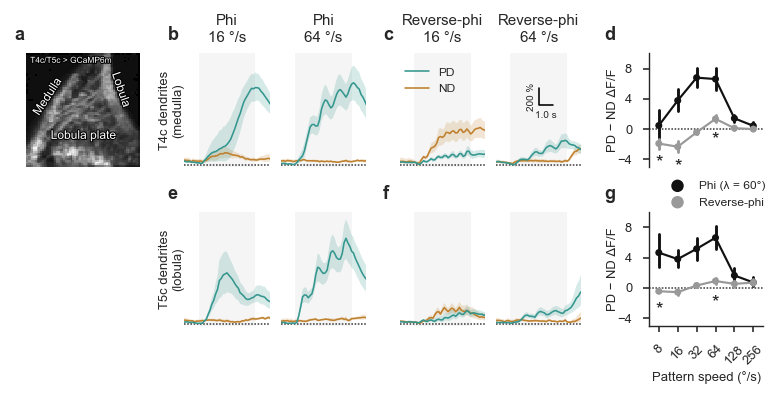

In [52]:
calcium_figure()